In [121]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
import plotly
import cufflinks
plotly.__version__

'4.14.3'

In [122]:
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *


In [123]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [124]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [125]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [126]:
import yfinance as yf
def dl(stock, start, end):
    subset = yf.download(stock, start=start, end=end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start:end]
    subset2 = subset[start:end]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)


In [127]:
import pandas as pd
end = pd.Timestamp.utcnow()
start = (end - 2500 * pd.tseries.offsets.BDay())
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [128]:
symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']

stocks = []
for i in symbols:
    stocks.append(dl(i,start,end))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [129]:
return_vec = np.zeros(shape=(len(stocks),len(stocks[0].iloc[:,3])-1))

for i in range(0,len(stocks)):
    intArray = np.array(np.log(1+stocks[i].iloc[:,3].pct_change().dropna()))
    extArray[i] = intArray
    
pd.DataFrame(return_vec.T)

,0,1,2,3,4,5,6
0,-0.017925,0.000239,-0.027919,-0.020643,-0.024326,0.032926,0.000095
1,0.014072,0.009987,0.018655,0.002268,0.000769,-0.012553,0.000237
2,0.018210,0.015612,0.019075,0.014142,0.019796,-0.013828,0.000118
3,-0.004924,-0.005079,-0.004321,-0.007046,-0.010610,0.001203,0.000000
4,0.005031,0.023886,0.010515,-0.001276,0.020736,0.006333,-0.000237
...,...,...,...,...,...,...,...
2404,-0.000138,0.001759,0.011643,0.013226,0.022624,0.003698,0.000232
2405,-0.006447,0.009032,-0.022908,-0.001575,0.003741,0.009221,0.000000
2406,-0.002855,-0.001744,0.011604,-0.000394,-0.000914,-0.001722,0.000232
2407,0.003064,0.000394,-0.006468,-0.012454,-0.008706,-0.004031,0.000000


In [135]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(extArray) 
    for _ in range(n_portfolios)
])


<ipython-input-125-be24d9d967e1>:9: RuntimeWarning:

Degrees of freedom <= 0 for slice

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide

/mnt/distvol/Python-3.9.4/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

invalid value encountered in multiply



TypeError: imported array must have 1 or 2 dimensions

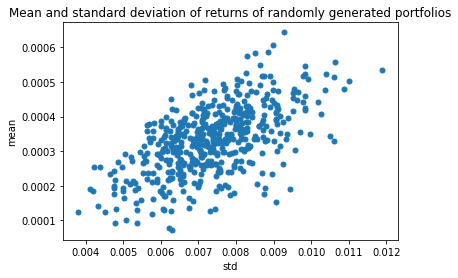

In [136]:

fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
#py.iplot_mpl(fig, filename='mean_std', strip_style=True)

weights, returns, risks = optimal_portfolio(return_vec)

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

Text(0, 0.5, 'returns')

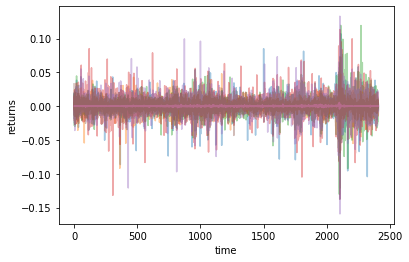

In [131]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py 
from plotly.graph_objs import *

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *
fig = plt.figure()
plt.plot(extArray.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
#py.iplot_mpl(fig, filename='s6_damped_oscillation')